In [1]:
# Skracena verzija 01-pix2pix-mnist-long 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
from typing import Tuple
from dataclasses import dataclass
from datetime import datetime
import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds

from PIL import Image
from IPython import display

In [2]:
# Parametri okruzenja
MASTER_FOLDER = 'pix2pix' # Folder gde se cuvaju svi rezultati
BATCH_SIZE = 40 
IMG_SIZE = 32 # Pozeljno je da dimenzija slike bude stepen dvojke zbog U-NET modela
IMG_CHANNELS = 1
SKUP_PODATAKA = 'mnist' # 'fashion_mnist'

In [3]:
from library.mnist import prepare_mnist_dataset
tf_train, tf_test = prepare_mnist_dataset('mnist')

In [4]:
from library.unet_generator import UNetGeneratorBuilder

def create_generator(*args, **kwargs):
    generator_builder = UNetGeneratorBuilder(*args, **kwargs)
    generator_builder.add_downsample_layer(16, 3, apply_batchnorm=True)
    generator_builder.add_downsample_layer(32, 3)
    generator_builder.add_upsample_layer(16, 3, apply_dropout=True)
    return generator_builder.build()

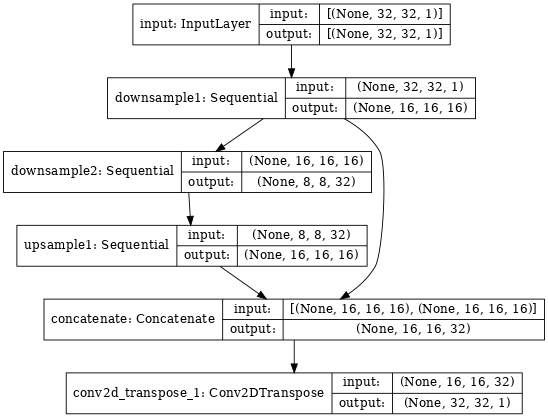

In [5]:
generator = create_generator(input_size=IMG_SIZE, output_channels=IMG_CHANNELS)
keras.utils.plot_model(generator, show_shapes=True, dpi=64)

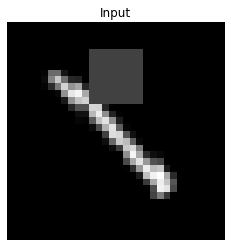

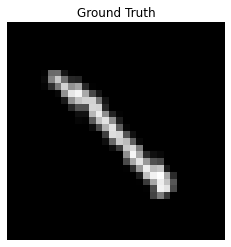

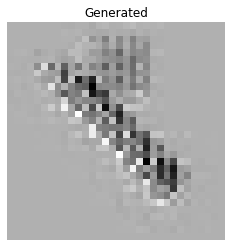

In [6]:
from library.visualization import show_image

# Testiranje Generatora
for x, y in tf_train.take(1):
    show_image(x[0], title='Input')
    show_image(y[0], title='Ground Truth')
    show_image(generator(x)[0], title='Generated')

In [7]:
from library.unet_generator import downsample

def create_discriminator(input_size: int):
    """
    Diskriminator se sastoji iz niza "downsample" slojeva.
    Napomena: Diskriminator ocenjuje nekoliko ravnomerno rasporedjenih kvadrata na slici
    i za svaki govori da li je slika prava ili ne. 

    :param input_size: Dimenzija ulazne slike
    :return: Diskriminator
    """
    inputs = layers.Input(shape=[input_size, input_size, 1], name='disc_input')
    target = layers.Input(shape=[input_size, input_size, 1], name='disc_target')

    x = layers.concatenate([inputs, target])

    x = downsample(16, 4, apply_batchnorm=False)(x)
    x = downsample(32, 4)(x)
    x = layers.Conv2D(1, 5, strides=1)(x)
    x = layers.Conv2D(1, 4, strides=1)(x)

    return keras.Model(inputs=[inputs, target], outputs=x)

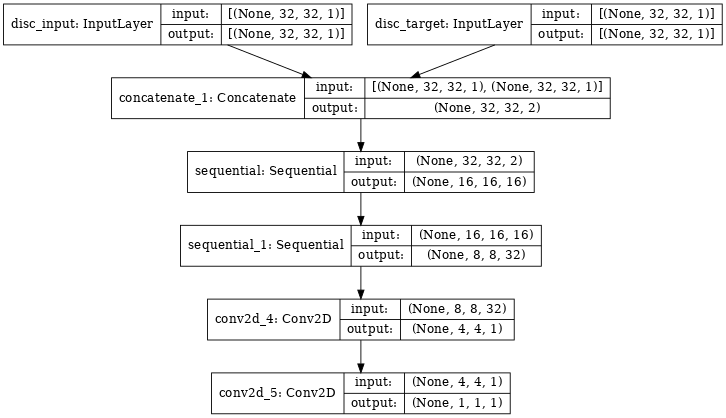

In [8]:
discriminator = create_discriminator(input_size=IMG_SIZE)
keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [9]:
# Podesavanje optimizatora
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [10]:
# Podesavanje parametara za periodicnog cuvanja stanja modela
checkpoint_dir = f'{MASTER_FOLDER}/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator=discriminator)

In [11]:
# Podesavanje logovanja
summary_writer = tf.summary.create_file_writer(f'{MASTER_FOLDER}/logs/fit/{datetime.now().strftime("%Y%m%d-%H%M%S")}')

Time taken for 5000 steps: 52.67 sec



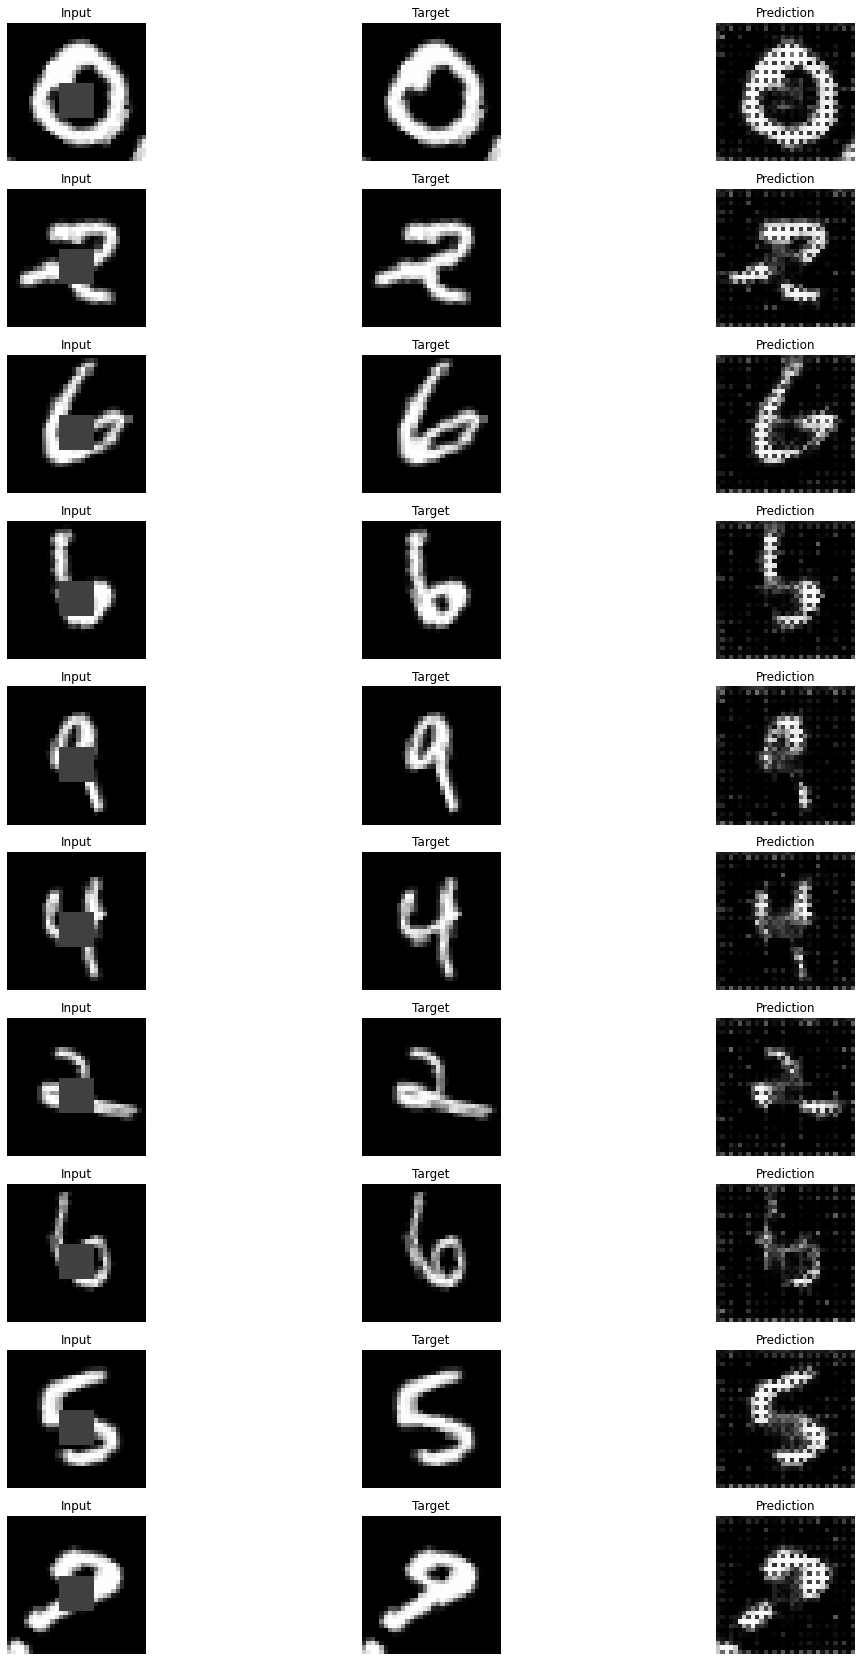

Step: 5000
.

In [12]:
from library.cgan import CGAN

cgan = CGAN(
  generator=generator,
  discriminator=discriminator,
  alpha=1e-2,
  generator_optimizer=generator_optimizer,
  discriminator_optimizer=discriminator_optimizer,
  summary_writer=summary_writer,
  checkpoint=checkpoint,
  checkpoint_prefix=checkpoint_prefix
)
train_history, val_history = cgan.fit(tf_train, tf_test, steps=5000, test_generation_period=1000, n_test_examples=10)